In [1]:
import numpy as np
import pandas as pd
import csv
import sklearn as sk
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
%matplotlib inline

In [3]:
# Read in data

train = 'data/newtrain.csv'
test = 'data/newtest.csv'
tr_dat = pd.read_csv(train)
te_dat = pd.read_csv(test)
geo_feats = pkl.load(open('neighbor_feat.jpg', 'rb'))

In [4]:
# %%timeit

# Get count /sensor /hour over all days
# Note: first column is padded w/ all zeros

n_sensors = 56
n_days = 30
n_hours = 24

hour_count = np.zeros((n_days*n_hours, n_sensors))
#num_nans = []

for i in xrange(n_sensors):
    for j in xrange(n_days):
        for k in xrange(n_hours):
            offset = j*1440 + k*60
            min_count = tr_dat.iloc[:,i][offset:offset+60]
            n_nans = np.count_nonzero(np.isnan(min_count))
            if n_nans > 0:
                hour_count[j*24+k][i] = -1
#                num_nans.append(n_nans)
            else:
                hour_count[j*24+k][i] = np.sum(tr_dat.iloc[:,i+1][offset:offset+60])

In [5]:
# train feats and target
dom = pd.get_dummies(np.reshape(np.transpose(np.tile(np.arange(30), (24,1))), (720,)))
dow = pd.get_dummies(np.reshape(np.transpose(np.tile(np.arange(30), (24,1))), (720,)) % 7)
hour = pd.get_dummies(np.reshape(np.tile(np.arange(24), (30,1)), (720,)))
time_feats = np.hstack((dom, dow, hour))
feats = np.hstack((np.repeat(time_feats, 56, axis=0), pd.get_dummies(np.tile(np.arange(56), 720)), np.reshape(geo_feats, (720*56,1))))

In [287]:
# drop NaNs
targets = np.reshape(hour_count, np.size(hour_count))
to_remove = np.where(targets >= 0)
y = targets[to_remove[0]]
X = feats[to_remove[0]]

In [14]:
# use geo data as target
targets = np.reshape(hour_count, np.size(hour_count))
to_remove = np.where(targets < 0)
for row in to_remove[0]:
    targets[row] = geo_feats[feats[row][0]*24+feats[row][2]][feats[row][3]]
y = targets
X = feats

In [12]:
# test feats

te_sensors = pd.get_dummies(range(56) + [int(x[1:]) for x in te_dat.iloc[:,0]])[56:]

te_dom = pd.get_dummies(te_dat['start_day'])
te_dow = pd.get_dummies(te_dat['start_day'] % 7)

te_hour = pd.get_dummies(range(24) + list(te_dat.iloc[:,4]))[24:]
te_geo_feat = np.array([geo_feats[24*(row[3] -1) + row[4]][int(row[0][1:])] for i, row in te_dat.iterrows()])
te_geo_feat = np.reshape(te_geo_feat, (np.size(te_geo_feat),1))
te_feats = np.hstack((te_dom, te_dow, te_hour, te_sensors, te_geo_feat))

In [184]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge = ridge.fit(X, y)
ridge_preds = ridge.predict(te_feats)

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 50)
rf = rf.fit(X,y)

In [17]:
rf_preds = rf.predict(te_feats)
print rf_preds

[ 7.06  5.6   5.34 ...,  0.62  1.08  1.58]


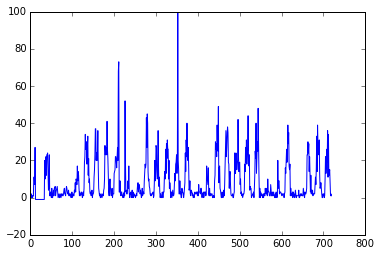

In [117]:
# NOW SENSORS ARE ONE-INDEXED (first col is all zeros)

plt.plot(hour_count[:,2])
#plt.plot(hour_count[:,3])
#plt.plot(hour_count[:,7])
#plt.plot(hour_count[:,33])
plt.show()

In [40]:
# Random predictions

s = {'Count': pd.Series(np.random.randn(np.shape(te_dat)[0]), index=np.array(range(np.shape(te_dat)[0]))+1)}
s = pd.DataFrame(s)

In [18]:
# Write predictions

s = {'Count': pd.Series(rf_preds, index=np.array(range(np.shape(te_dat)[0]))+1)}
s = pd.DataFrame(s)
pred_file = 'rf_preds.txt'
s.to_csv(pred_file, header=True, index=True, index_label="Index")